## Architecture: 

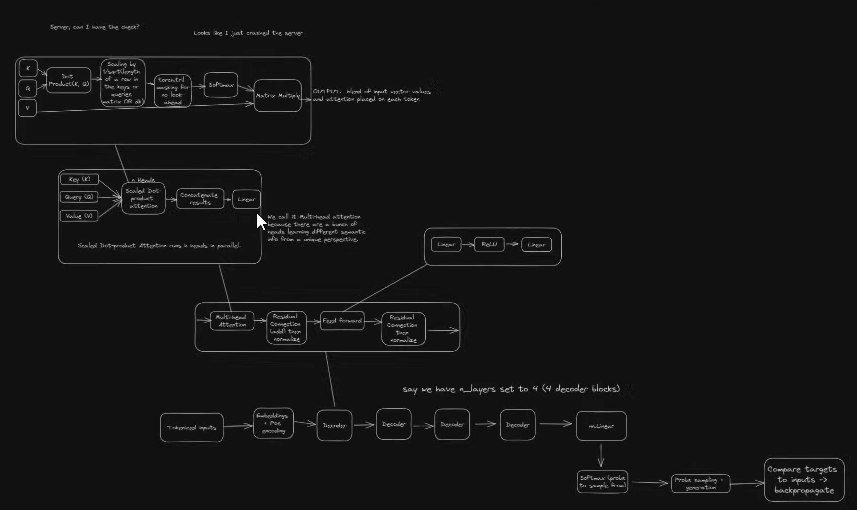

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

block_size = 8
batch_size = 4
max_iter = 10000
eval_iter = 250
learning_rate = 3e-4
n_embd = 384
n_layer = 4

cuda


In [4]:
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(set(text))
vocab_size = len(chars)

In [5]:
string_to_int = { ch:i for i,ch in enumerate(chars)}
int_to_string = { i:ch for i,ch in enumerate(chars)}
encode = lambda s:[string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

In [6]:
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # print(ix)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [7]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train','val']:
        losses = torch.zeros(eval_iter)
        for k in range(eval_iter):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out     

In [8]:
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block[n_embd, n_head=n_head for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, index, targets=None):
        logits = self.token_embedding_table(index)
        
        #idx and targets are both (B,T) tensors of integer type
        tok_embd = self.token_embedding_table(idx) #(B,T,C)
        pos_embd = self.position_embedding_table(torch.arrange(T, device=device)) #(T,C)
        x = tok_emb + pos_emb #(B,T,C)
        x = sef.blocks(x) #(B,T,C)
        x = self.ln_f(x) #(B,T,C)
        logits = self.lm_head(x) #(B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self.forward(index)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim=1) # (B, T+1)
        return index

model = GPTLanguageModel(vocab_size)
m = model.to(device)

# context = torch.zeros((1,1), dtype=torch.long, device=device)
# generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
# print(generated_chars)

In [9]:
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)

for iter in range(max_iter):
    if iter%eval_iter == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")
    xb, yb = get_batch('train')
    logits, loss = model.forward(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step: 0, train loss: 5.0295, val loss: 5.0158
step: 250, train loss: 4.9564, val loss: 4.9785
step: 500, train loss: 4.8868, val loss: 4.8951
step: 750, train loss: 4.8361, val loss: 4.8263
step: 1000, train loss: 4.7838, val loss: 4.7758
step: 1250, train loss: 4.7167, val loss: 4.7130
step: 1500, train loss: 4.6695, val loss: 4.6427
step: 1750, train loss: 4.6065, val loss: 4.5956
step: 2000, train loss: 4.5506, val loss: 4.5297
step: 2250, train loss: 4.4914, val loss: 4.4986
step: 2500, train loss: 4.4319, val loss: 4.4442
step: 2750, train loss: 4.3963, val loss: 4.3952
step: 3000, train loss: 4.3246, val loss: 4.3184
step: 3250, train loss: 4.2739, val loss: 4.2826
step: 3500, train loss: 4.2338, val loss: 4.2297
step: 3750, train loss: 4.1759, val loss: 4.1821
step: 4000, train loss: 4.1452, val loss: 4.1329
step: 4250, train loss: 4.0851, val loss: 4.0857
step: 4500, train loss: 4.0444, val loss: 4.0324
step: 4750, train loss: 4.0056, val loss: 4.0210
step: 5000, train loss: 3.